In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchcps.kernel.rkhs import GaussianKernel
from torchcps.kernel.nn import (
    KernelConv,
    KernelMap,
    KernelGraphFilter,
    KernelNorm,
    Mixture,
)

In [7]:
# create a datset of 2D signals shifted by a fixed amount
n_points = 10
n_samples = 50000
shift = (-17, 3)
n_dimensions = len(shift)

with torch.no_grad():
    # located uniformly in a 25x25 square
    input = 25 * torch.rand(n_samples, n_points, n_dimensions) - 25 / 2
    # shifted by a fixed amount
    output = input + torch.tensor(shift)[None, None, :]

In [8]:
n_channels = 8
filter_kernels = 8
kernel_spred_coeff = 4
fixed_positions = False
kernel_size = 2
n_weights = 8
n_hidden = 32
filter_taps = 2
sigma = [6.0, 2.0]


class UpdatePositions(nn.Module):
    def __init__(self, n_dimensions, n_weights, n_layers, n_hidden) -> None:
        super().__init__()
        dims = n_dimensions + n_weights
        linears = []
        for i in range(n_layers):
            first_layer = i == 0
            last_layer = i == n_layers - 1
            linears.append(
                nn.Linear(
                    dims if first_layer else n_hidden,
                    dims if last_layer else n_hidden,
                )
            )
        self.linears = nn.ModuleList(linears)

    def forward(self, input: Mixture):
        """
        Args:
            input (Mixture): with the following elements.
                positions: (batch_size, n_channels, in_kernels, n_dimensions)
                weights: (batch_size, n_channels, in_kernels, in_weights)
        """
        x = torch.cat([input.positions, input.weights], dim=-1)
        for linear in self.linears:
            x = linear(x)
            x = nn.LeakyReLU()(x)
        positions = x[..., :n_dimensions] + input.positions
        weights = x[..., n_dimensions:] + input.weights
        return Mixture(positions, weights)


model_factory = lambda: nn.Sequential(
    KernelMap(nn.Linear(1, n_weights)),
    UpdatePositions(2, n_weights, 2, n_hidden),
    KernelNorm(1, n_weights),
    KernelConv(
        filter_kernels=filter_kernels,
        in_channels=1,
        out_channels=n_channels,
        n_dimensions=2,
        kernel_spread=kernel_spred_coeff * sigma[0] * filter_kernels**0.5,
        n_weights=n_weights,
        fixed_positions=fixed_positions,
    ),
    KernelGraphFilter(
        kernel=GaussianKernel(kernel_size),
        in_weights=n_weights,
        out_weights=n_weights,
        filter_taps=filter_taps,
        normalize=True,
    ),
    KernelMap(nn.LeakyReLU()),
    UpdatePositions(2, n_weights, 2, n_hidden),
    KernelNorm(n_channels, n_weights),
    KernelConv(
        filter_kernels=filter_kernels,
        in_channels=n_channels,
        out_channels=1,
        n_dimensions=2,
        kernel_spread=kernel_spred_coeff * sigma[1] * filter_kernels**0.5,
        n_weights=n_weights,
        fixed_positions=fixed_positions,
    ),
    KernelGraphFilter(
        kernel=GaussianKernel(kernel_size),
        in_weights=n_weights,
        out_weights=n_weights,
        filter_taps=filter_taps,
        normalize=True,
    ),
    KernelMap(nn.LeakyReLU()),
    UpdatePositions(2, n_weights, 2, n_hidden),
    KernelMap(nn.Linear(n_weights, 1)),
).cuda()

In [9]:
from torch.optim import AdamW
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(input.cuda(), output.cuda())
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = model_factory()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0)

mse_values = []

pbar = tqdm(dataloader, total=len(dataloader), position=1, leave=False)
for x, y in pbar:
    x = x[:, None, ...]
    y = y[:, None, ...]
    x_weights = torch.ones(*x.shape[:-1], device="cuda")[..., None]
    y_weights = torch.ones(*y.shape[:-1], device="cuda")[..., None]

    z, z_weights = model(Mixture(x, x_weights))
    kernel = GaussianKernel(kernel_size)
    mse = kernel.squared_error(y, y_weights, z, z_weights).mean(0).sum()

    mse_values.append(mse.item())
    pbar.set_postfix(loss=mse.item())

    mse.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/1563 [00:00<?, ?it/s]

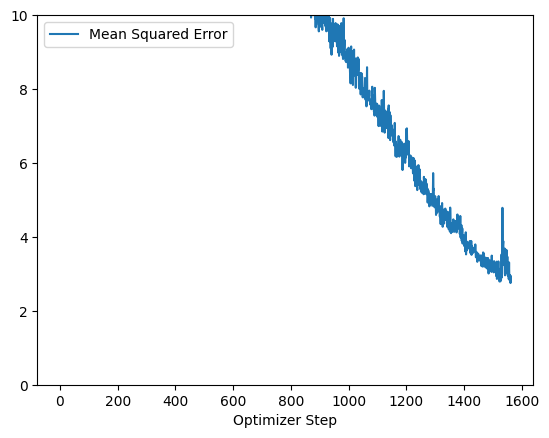

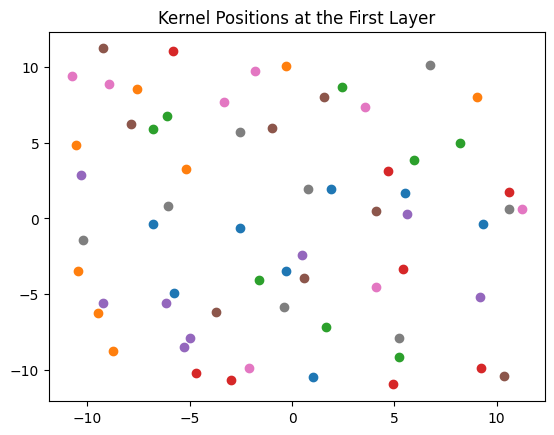

In [10]:
import matplotlib.pyplot as plt

plt.plot(mse_values, label="Mean Squared Error")
plt.xlabel("Optimizer Step")
plt.ylim(0, 10)
plt.legend()
plt.show()

# get the convolutional layers
conv_layers = [layer for layer in model if isinstance(layer, KernelConv)]

# plot the kernel positions
plt.figure()
plt.title("Kernel Positions at the First Layer")
plt.plot(*conv_layers[1].kernel_positions.detach().squeeze().cpu().numpy().T, "o")
plt.show()

In [11]:
def raster_rkhs(X: Mixture, sigma: float, width: float, resolution: int):
    XY = (
        torch.stack(
            torch.meshgrid(
                torch.linspace(-width / 2, width / 2, resolution),
                torch.linspace(-width / 2, width / 2, resolution),
            ),
            dim=-1,
        )
        .reshape(-1, 2)
        .to(X.positions.device)
    )
    kernel = GaussianKernel(sigma)
    values = kernel(XY, X.positions[0, 0]) @ X.weights
    XY = XY.reshape(resolution, resolution, 2).detach()
    values = values.reshape(resolution, resolution).detach()
    return values, XY

In [12]:
input.shape

torch.Size([50000, 10, 2])

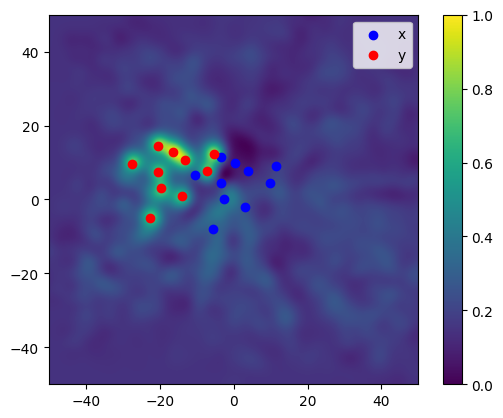

In [17]:
idx = np.random.randint(0, n_samples)
width = 100

with torch.no_grad():
    x = input[idx, None, None, ...].cuda()
    y = output[idx, None, None, ...].cuda()
    x_weights = torch.ones(*x.shape[:-1], device="cuda")[..., None]
    y_weights = torch.ones(*y.shape[:-1], device="cuda")[..., None]

    z, z_weights = model(Mixture(x, x_weights))
    values, XY = raster_rkhs(Mixture(z, z_weights), kernel_size, width, 1000)
    # squeeze all the tensors
    x = x.squeeze().cpu().numpy()
    y = y.squeeze().cpu().numpy()

# plot the prediction as an intensity
plt.figure()
plt.imshow(
    values.T.cpu(),
    extent=(-width / 2, width / 2, -width / 2, width / 2),
    origin="lower",
)
plt.scatter(*x.T, c="blue", label="x")
plt.scatter(*y.T, c="red", label="y")
plt.legend()
plt.colorbar()
plt.show()